In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Embedding, Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.optimizers as optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,precision_score,recall_score,auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import (LabelEncoder,OneHotEncoder, StandardScaler)  
from sklearn import model_selection
from sklearn.externals import joblib
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import math
import os
import shutil
import zipfile
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Cargando objetos necesarios para funcionar los modelos
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alonsopuente","key":"a2490af4bf49c88fb2df45cdbad9784f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alonsopuente/thesis-objects
!ls
os.mkdir('folder')
zip_train_test_md = zipfile.ZipFile('thesis-objects.zip','r')
zip_train_test_md.extractall()
zip_train_test_md.close()
os.rename('thesis-objects.zip','folder/thesis-objects.zip')
shutil.rmtree('folder')

 26% 9.00M/34.4M [00:00<00:00, 33.6MB/s]
100% 34.4M/34.4M [00:00<00:00, 99.2MB/s]
kaggle.json  sample_data  thesis-objects.zip


In [ ]:
# Se tiene que dar acceso a Drive para almacenar el mejor modelo del checkpoint
# Fuente:
# https://medium.com/@mukesh.kumar43585/model-checkpoint-google-colab-and-drive-as-persistent-storage-for-long-training-runs-e35ffa0c33d9

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
X_train_metadata = np.load('metadata_X_train.npy',allow_pickle=True)
X_test_metadata = np.load('metadata_X_test.npy',allow_pickle=True)
X_train_description = np.load('description_X_train.npy',allow_pickle=True)
X_test_description = np.load('description_X_test.npy',allow_pickle=True)
X_train_comments = np.load('comments_X_train.npy',allow_pickle=True)
X_test_comments = np.load('comments_X_test.npy',allow_pickle=True)
y_train = np.load('description_Y_train.npy',allow_pickle=True)
y_test = np.load('description_Y_test.npy',allow_pickle=True)

In [ ]:
X_test_metadata

array([[4.99900005e-05, 1.13259302e-06, 1.44444444e-01, 1.39534884e-01,
        1.59948585e-05, 6.43382353e-05],
       [5.99900006e-05, 9.23918654e-06, 2.66666667e-01, 9.30232558e-02,
        1.56574669e-04, 2.78492647e-04],
       [3.49900003e-05, 2.52810942e-08, 3.22222222e-01, 1.16279070e-01,
        2.49919664e-07, 3.67647059e-05],
       ...,
       [3.34900003e-05, 7.92392504e-07, 3.22222222e-01, 4.65116279e-02,
        7.49758991e-06, 5.51470588e-05],
       [2.99990003e-04, 9.24656019e-07, 3.22222222e-01, 6.97674419e-02,
        7.83498146e-05, 4.59558824e-05],
       [4.99900005e-05, 4.61266204e-05, 3.22222222e-01, 9.30232558e-02,
        6.51415603e-04, 7.62867647e-05]])

In [ ]:
X_test_comments

array([[  53,    0,    0, ...,    0,    0,    0],
       [  77, 1111,   55, ...,    0,    0,    0],
       [  53,    0,    0, ...,    0,    0,    0],
       ...,
       [  53,    0,    0, ...,    0,    0,    0],
       [ 886,  101,  122, ...,    0,    0,    0],
       [  27,  860,    3, ...,    0,    0,    0]], dtype=int32)

# Cargar modelos

Probaré con la información de este proyecto:
https://www.kickstarter.com/projects/theifs/new-toy-robot-game-makes-learning-to-code-childs-play

## Forma manual

In [ ]:
metadata_path_NN = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/best_NN_metadata_model.h5'
loaded_model_metadata_mln = load_model(metadata_path_NN)
loaded_model_metadata_mln.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
description_path_CNN = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/best_CNN_description_model.h5'
loaded_model_description_cnn = load_model(description_path_CNN)
loaded_model_description_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_description (Embed (None, 3671, 100)         14827000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3667, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,899,449
Trainable params: 14,899,449
Non-trainable params: 0
____________________________________________

In [ ]:
comments_path_RNN = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/best_RNN_comments_model.h5'
loaded_model_comments_rnn = load_model(comments_path_RNN)
loaded_model_comments_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_comments (Embeddin (None, 5000, 100)         7409600   
_________________________________________________________________
dropout (Dropout)            (None, 5000, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 7,644,353
Trainable params: 234,753
Non-trainable params: 7,409,600
_________________________________________________________________


In [ ]:
members = list()
members.append(loaded_model_description_cnn)
members.append(loaded_model_comments_rnn)
members.append(loaded_model_metadata_mln)

## Forma rápida

In [ ]:
# Función para cargar modelos dentro de una ruta
def load_all_models(models_path):
  all_models = list()
  for i in os.listdir(models_path):
    # define filename for this ensemble
    filename = i
    # load model from file
    model = load_model(models_path + filename)
    # add to list of members
    all_models.append(model)
    print('>loaded %s' % filename)
  return all_models

In [ ]:
# Cargando los modelos
models_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/'
members = load_all_models(models_path)
print('Loaded %d models' % len(members))

>loaded best_NN_metadata_model.h5
>loaded best_RNN_comments_model.h5
>loaded best_CNN_description_model.h5
Loaded 3 models


In [ ]:
members[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_description (Embed (None, 3671, 100)         14827000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3667, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,899,449
Trainable params: 14,899,449
Non-trainable params: 0
____________________________________________

In [ ]:
members[1].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_comments (Embeddin (None, 5000, 100)         7409600   
_________________________________________________________________
dropout (Dropout)            (None, 5000, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 7,644,353
Trainable params: 234,753
Non-trainable params: 7,409,600
_________________________________________________________________


In [ ]:
members[2].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


## Evaluando por separado cada modelo cargado

In [ ]:
# Descripción
description_acc = members[0].evaluate(X_test_description, y_test, verbose=1)
print('Model Accuracy: %.3f' % description_acc[1])

171/171 [==============================] - 7s 17ms/step - loss: 0.4901 - accuracy: 0.7683
Model Accuracy: 0.768


In [ ]:
# Comentarios
comments_acc = members[1].evaluate(X_test_comments, y_test, verbose=1)
print('Model Accuracy: %.3f' % comments_acc[1])

171/171 [==============================] - 28s 158ms/step - loss: 0.4472 - accuracy: 0.8510
Model Accuracy: 0.851


In [ ]:
# Metadata
metadata_acc = members[2].evaluate(X_test_metadata, y_test, verbose=1)
print('Model Accuracy: %.3f' % metadata_acc[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.2060 - accuracy: 0.9310
Model Accuracy: 0.931


# Ensamblando modelos

In [ ]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight('balanced', np.unique(np.concatenate([y_train, y_test])), np.concatenate([y_train, y_test]))
# Para que funcione correctamente los pesos de las clases balanceadas, se almacenan como diccionarios
class_weights = {i : class_weights[i] for i in range(2)}
print(class_weights)

{0: 0.6987077585764833, 1: 1.7581290322580645}


In [ ]:
# Fuentes:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://maelfabien.github.io/deeplearning/regu/#

# Para detener el entrenamiento cuando la pérdida en data de prueba empieza a subir. Límite de 2 incrementos.
# Para pérdida se usa mínimo. Para precisión se usa máximo
early_stopper = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

# Para reducir tasa de aprendizaje cuando es muy grande
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=5, verbose=1, min_delta=1e-4, mode='max')

In [ ]:
from keras.callbacks import *
checkpoint_path_stacked_model ="/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_stacked_model_epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint_stacked = ModelCheckpoint(filepath=checkpoint_path_stacked_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(1, activation='sigmoid')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# compile
	opt = tf.keras.optimizers.Adam(learning_rate= 1e-5, decay=1e-5)
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 	# plot graph of ensemble
	model.summary()
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	return model

In [ ]:
# define ensemble model
stacked_model = define_stacked_model(members)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Embedding_description_input (In [(None, 3671)]       0                                            
__________________________________________________________________________________________________
ensemble_1_Embedding_descriptio (None, 3671, 100)    14827000    Embedding_description_input[0][0]
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
ensemble_1_conv1d (Conv1D)      (None, 3667, 128)    64128       ensemble_1_Embedding_description[
______________________________________________________________________________________________

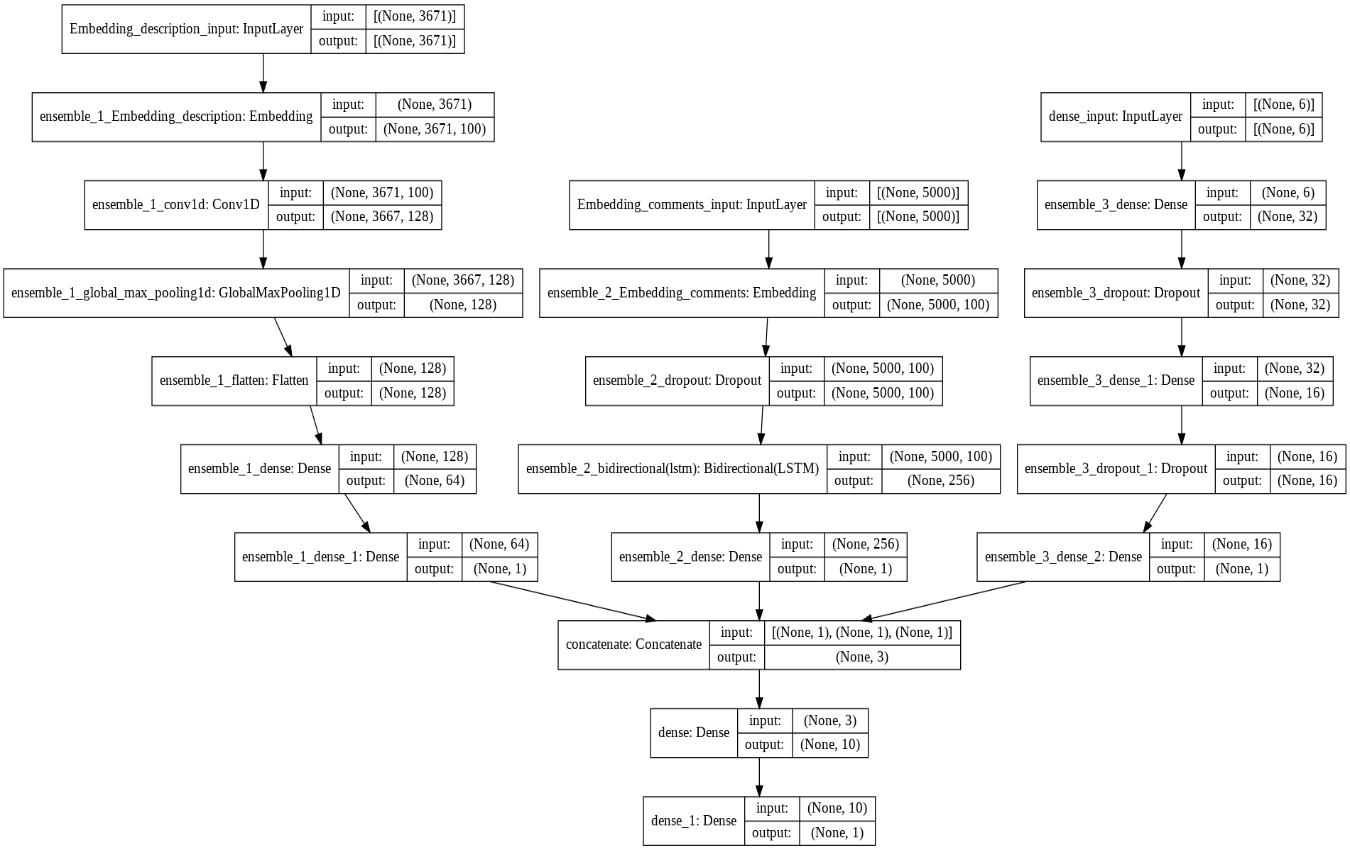

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
stacked_model_img = cv2.imread('model_graph.png', cv2.IMREAD_UNCHANGED)
stacked_model_img = cv2.resize(stacked_model_img, (1350, 850))
cv2_imshow(stacked_model_img)

In [ ]:
X_train_stacked = [X_train_description, X_train_comments, X_train_metadata]
X_test_stacked = [X_test_description, X_test_comments, X_test_metadata]

In [ ]:
num_epochs = 200
#batch_size = 128
# fit a stacked model
start = datetime.now()
hist_stacked = stacked_model.fit(X_train_stacked,
            y_train,
            epochs=num_epochs,
            #batch_size=batch_size,
            validation_data=(X_test_stacked, y_test),
            verbose=1,
            class_weight=class_weights,
            callbacks=[early_stopper, reduce_lr_acc, checkpoint_stacked],
            shuffle=False)
stop=datetime.now()
execution_time_stacked = stop-start
print('\n')
print('Tiempo de ejecución:',execution_time_stacked)

Epoch 1/200
682/682 [==============================] - 152s 219ms/step - loss: 0.5271 - accuracy: 0.8131 - val_loss: 0.2153 - val_accuracy: 0.9369

Epoch 00001: val_loss improved from inf to 0.21531, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_stacked_model_epochs:001-val_accuracy:0.937.hdf5
Epoch 2/200
682/682 [==============================] - 150s 219ms/step - loss: 0.1875 - accuracy: 0.9395 - val_loss: 0.1820 - val_accuracy: 0.9341

Epoch 00002: val_loss improved from 0.21531 to 0.18197, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_stacked_model_epochs:002-val_accuracy:0.934.hdf5
Epoch 3/200
682/682 [==============================] - 150s 220ms/step - loss: 0.1631 - accuracy: 0.9400 - val_loss: 0.1810 - val_accuracy: 0.9336

Epoch 00003: val_loss improved from 0.18197 to 0.18097, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos gua

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_stacked_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_stacked_model_epochs:003-val_accuracy:0.934.hdf5'
stacked_model.load_weights(checkpoint_best_stacked_path)

In [ ]:
score = stacked_model.evaluate(X_test_stacked, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 30s 168ms/step - loss: 0.1766 - accuracy: 0.9332
Test loss:  0.1809707134962082
Test accuracy:  0.9335901737213135


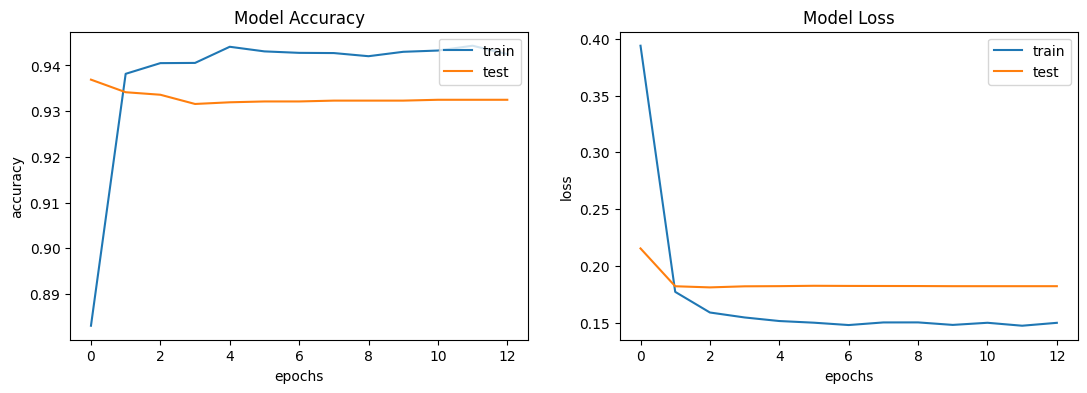

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_stacked.history['accuracy'])
subfig.plot(hist_stacked.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_stacked.history['loss'])
subfig.plot(hist_stacked.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

171/171 [==============================] - 31s 176ms/step


(2.5, -0.5)

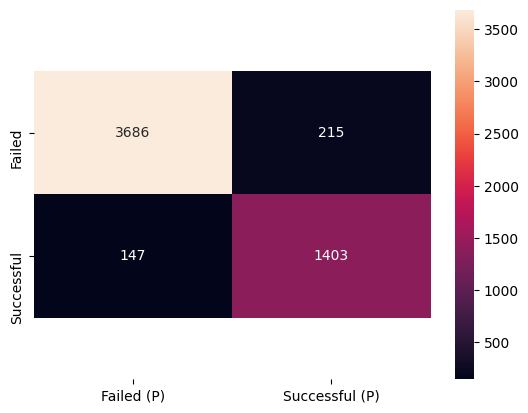

In [ ]:
y_pred = stacked_model.predict(X_test_stacked,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_stacked = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_stacked = sns.heatmap(conf_stacked, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_stacked.get_ylim()
ax_stacked.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.96      0.94      0.95      3901
  Successful       0.87      0.91      0.89      1550

    accuracy                           0.93      5451
   macro avg       0.91      0.93      0.92      5451
weighted avg       0.93      0.93      0.93      5451



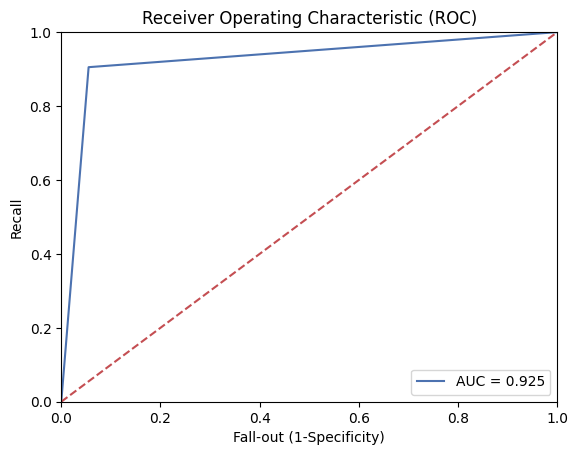

AUC score: 0.925023608504023


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_stacked = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_stacked)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_stacked)

In [ ]:
# save the model to disk
best_stacked_model_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/best_stacked_model.h5'
stacked_model.save(best_stacked_model_path)